In [16]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer, minmax_scale
from sklearn.mixture import BayesianGaussianMixture

from sklearn.metrics import pairwise_distances, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

from tqdm import tqdm

In [4]:
# load
data_path = pathlib.Path().joinpath('data', 'data.csv')
data = pd.read_csv(data_path, index_col='id')

# int as dummies
# int_columns = data.columns[data.dtypes == int]
# dummies = pd.get_dummies(data[int_columns].astype('category'))
# data = pd.concat([data.drop(int_columns, axis=1), dummies], axis=1)

# PowerTransform int
# int_columns = data.columns[data.dtypes == int]
# data[int_columns] = power_transform(data[int_columns])

# prepare data
scaled = make_pipeline(
    PowerTransformer(),
    MaxAbsScaler(),
).fit_transform(data)

# select columns
col_names = [f'f_{n:02d}' for n in (*range(7, 14), *range(22, 29))]
usecols = np.arange(data.shape[1])[data.columns.isin(col_names)]
selected = scaled[:, usecols]
# others = np.arange(data.shape[1])[~data.columns.isin(col_names)]
# leftcols = scaled[:, others]

In [9]:
def multiple_clustering(X, *, frac=1.0, iters=3, seed=None, **kwargs):
    n_clusters = kwargs.get('n_clusters', 5)
    n_init = kwargs.get('n_init', 1)
    tol = kwargs.get('tol', 1e-3)

    assert (frac > 0) and (frac <= 1), "frac must be > 0 and <= 1"
    np.random.seed(seed)

    labels = []
    score = np.zeros((X.shape[0], n_clusters))
    probability = np.zeros((X.shape[0], n_clusters))
    n_feats = np.ceil(frac * X.shape[1]).astype(int)
    for i in tqdm(range(iters), desc='fit', total=iters):
        feats = np.random.choice(range(X.shape[1]), n_feats, replace=False)
        bgm = BayesianGaussianMixture(n_components=n_clusters, n_init=n_init, tol=tol, random_state=np.random.randint(2 ** 16)).fit(X[:, feats])
        proba = bgm.predict_proba(X[:, feats])
        cluster = proba.argmax(axis=1)
        
        # translate labels
        order = pd.Series(cluster).value_counts().index
        remap = dict(zip(order, range(n_clusters)))
        lb = np.vectorize(remap.get)(cluster)
        labels.append(lb)
        # update proba
        probability += proba[:, order]
        # calc mean vec
        mean_vec = [X[lb == cl].mean(axis=0) for cl in range(n_clusters)]
        if i == 0:
            base_mean_vec = np.copy(mean_vec)
        # distance & weights
        dist = pairwise_distances(base_mean_vec, mean_vec, metric='euclidean')
        weights = 1 / (1 + dist ** 2)
        # addition
        score += proba[:, order] @ weights.T

    # bundle translated labels
    bundle = np.c_[labels].T
    # count labels
    counter = np.apply_along_axis(lambda row: dict(zip(*np.unique(row, return_counts=True))), 1, bundle)
    count = pd.DataFrame(list(counter)).fillna(0)[range(n_clusters)].values
    return score, count, probability

In [10]:
def lgbm_labels(score_matrix, X, *, threshold=0.7, **kwargs):
    scaled_score = minmax_scale(score_matrix)
    lb = scaled_score.argmax(axis=1)
    train = scaled_score.max(axis=1) > threshold

    lgbm = LGBMClassifier(**kwargs).fit(X[train], lb[train])
    pred = lgbm.predict(X)
    return pred, accuracy_score(lb[train], pred[train]), accuracy_score(lb[~train], pred[~train])

In [11]:
# Kaggle 0.60604
scr, cnt, prb = multiple_clustering(selected, iters=50, n_clusters=7, n_init=3, tol=1e-2, seed=17)

labels, acc_train, acc_valid = lgbm_labels(scr, selected, threshold=0.7, random_state=17)
acc_train, acc_valid

fit: 100%|██████████| 50/50 [29:59<00:00, 36.00s/it]


(0.9812833051906756, 0.5992939099735216)

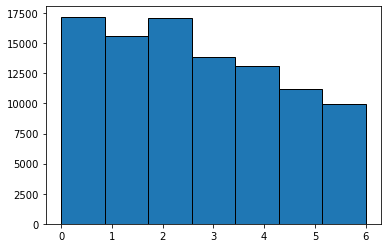

In [14]:
# clusters distribution
plt.hist(labels, edgecolor='black', bins=np.unique(labels).size)
plt.show()

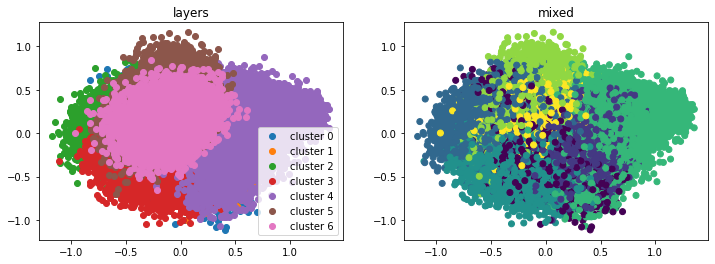

In [17]:
# plot
_, ax = plt.subplots(1, 2, figsize=(12, 4))
X2d = PCA(2, random_state=11).fit_transform(scaled)
ax[0].set_title('layers')
for lb in np.unique(labels):
    idx = labels == lb
    ax[0].scatter(X2d.T[0][idx], X2d.T[1][idx], label=f'cluster {lb}',)
ax[0].legend()
ax[1].set_title('mixed')
ax[1].scatter(X2d.T[0], X2d.T[1], c=labels);

In [18]:
# save submission
sub_path = pathlib.Path().joinpath('data', 'sample_submission.csv')
sub = pd.read_csv(sub_path)
sub['Predicted'] = labels
sub.to_csv('submission.csv', index=False)
sub

,Id,Predicted
0,0,3
1,1,6
2,2,3
3,3,4
4,4,0
...,...,...
97995,97995,6
97996,97996,2
97997,97997,1
97998,97998,5


In [ ]:
#